### Model Comparison: OLS Regression and KNN Regression

1) Find a data set and build a KNN Regression and an OLS regression. 

2) Compare the two. How similar are they? Do they miss in different ways?

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from scipy import stats
from scipy.stats.mstats import winsorize
import seaborn as sns
from math import sqrt
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')



In [2]:
#importing dataset
testscores = pd.read_csv('Admission_Predict.csv')

### Explore the data

In [3]:
#Removing white spaces from column names

testscores.columns = testscores.columns.str.strip()


In [4]:
testscores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
Serial No.           400 non-null int64
GRE Score            400 non-null int64
TOEFL Score          400 non-null int64
University Rating    400 non-null int64
SOP                  400 non-null float64
LOR                  400 non-null float64
CGPA                 400 non-null float64
Research             400 non-null int64
Chance of Admit      400 non-null float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


In [5]:
#Check for missing values
testscores.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [6]:
#Check descriptive statistics
testscores.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,200.500000,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,115.614301,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,100.750000,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,200.500000,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,300.250000,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,400.000000,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


2
3
4
5
6
7
8
9
10


ValueError: num must be 1 <= num <= 9, not 10

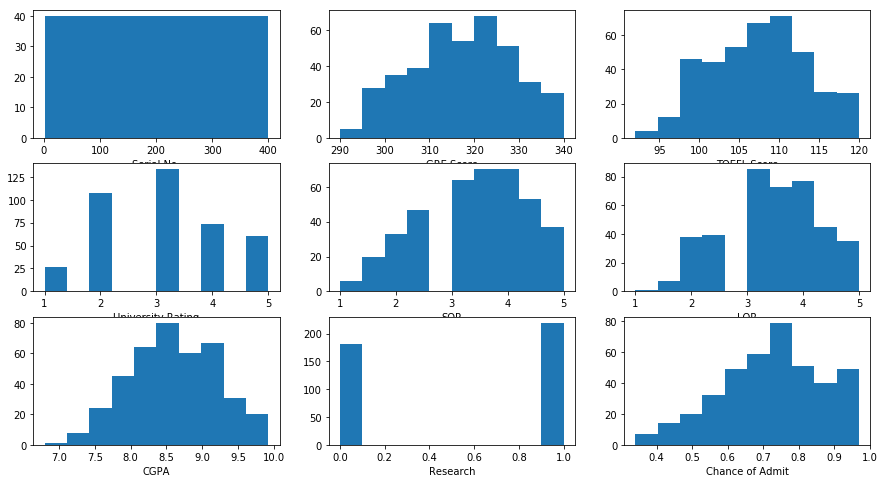

In [35]:
#Check distribution of variables

plt.figure(figsize=(15,8))

i=1

for column in testscores:
    plt.subplot(3, 3, i)
    plt.hist(testscores[column])
    plt.xlabel("{}".format(column))
    i+=1
    print(i)
    #plt.xlabel(i)
    
plt.show()

(array([ 7., 14., 20., 32., 49., 59., 79., 51., 40., 49.]),
 array([0.34 , 0.403, 0.466, 0.529, 0.592, 0.655, 0.718, 0.781, 0.844,
        0.907, 0.97 ]),
 <a list of 10 Patch objects>)

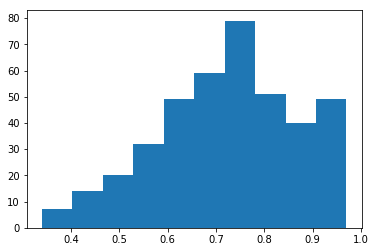

In [8]:
plt.hist(testscores['Chance of Admit'])

Relationships Between different Test Scores and The Chance to Be Admitted in College


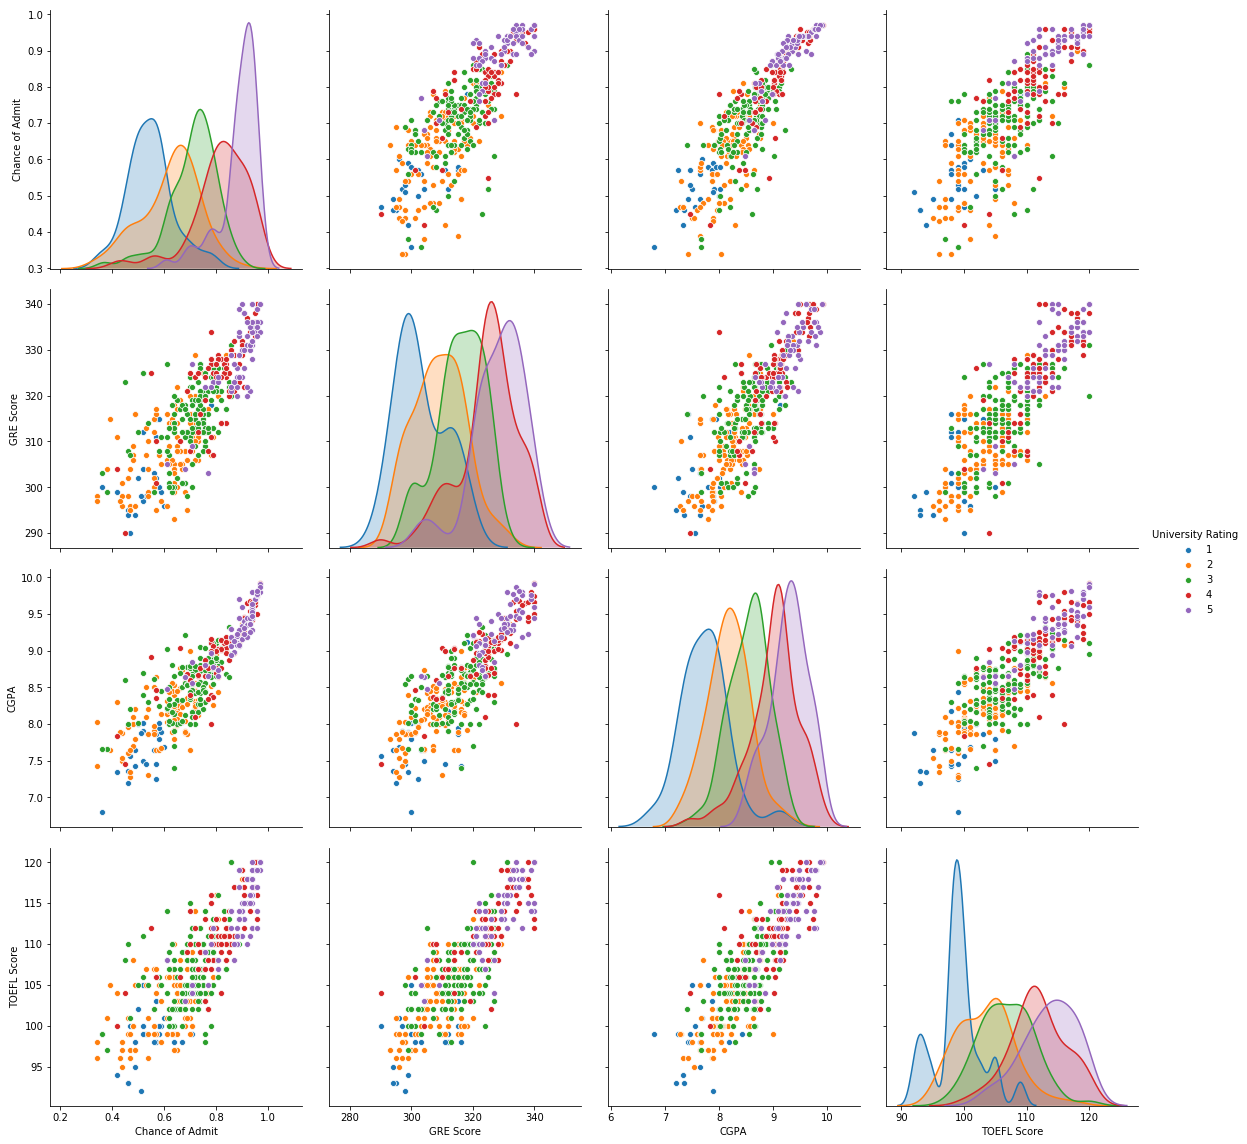

In [9]:

print('Relationships Between different Test Scores and The Chance to Be Admitted in College') 
g = sns.pairplot(testscores, 
                  x_vars=["Chance of Admit","GRE Score", "CGPA","TOEFL Score"],
                  y_vars=["Chance of Admit","GRE Score", "CGPA","TOEFL Score"],  
                  hue="University Rating",
                  height=4)

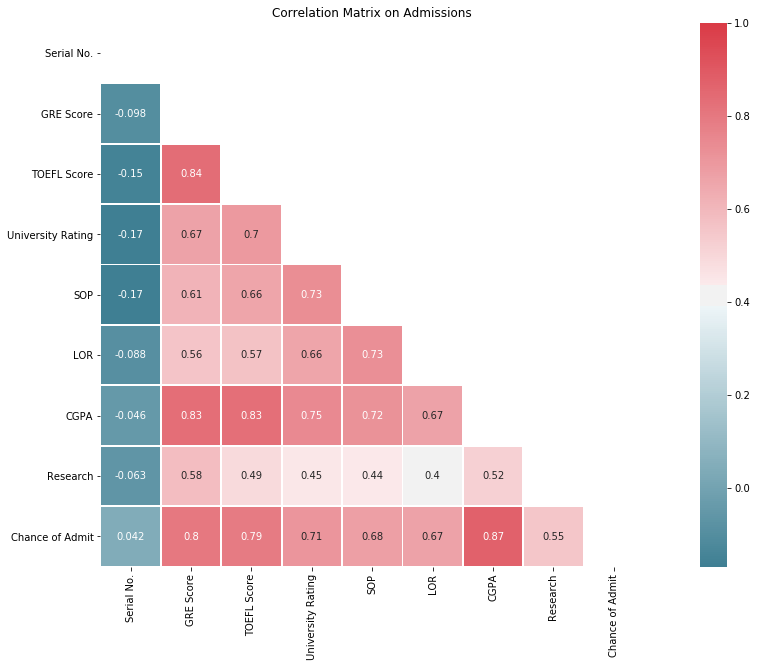

In [10]:
#Calculate correlations amonst variables

#Calcualte correlations
corrmat = testscores.corr()

mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True



#Set up figure and plot
plt.figure(figsize=(20,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrmat, cmap=cmap, mask=mask, square=True, annot=True, linewidths=.8)
plt.title("Correlation Matrix on Admissions")

plt.show()

### Build an OLS Regression model

In [11]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

#Create PCA components for SOP, LOR and Research

#Creating the 3 features we want
features=['SOP', 'LOR', 'Research']

#Separating the 3 features we want
a = testscores.loc[:,features].values

#Standardizing the features
a=StandardScaler().fit_transform(a)


sklearn_pca = PCA(n_components=1)
testscores['pca']=sklearn_pca.fit_transform(a)

print('The percentage of total variance in the dataset explained by each component from Sklearn PCA.\n', 
      sklearn_pca.explained_variance_ratio_)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.68750929]


In [12]:

# Y is the target variable
Y = testscores['Chance of Admit']

# X is the feature set which includes lot GRE, TOEFL and CGPA score
X = testscores[['GRE Score', 'TOEFL Score', 'CGPA', 'University Rating', 'pca']]

# We need to manually add a constant in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance of Admit   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     314.2
Date:                Thu, 12 Sep 2019   Prob (F-statistic):          5.09e-135
Time:                        21:11:10   Log-Likelihood:                 533.34
No. Observations:                 400   AIC:                            -1055.
Df Residuals:                     394   BIC:                            -1031.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.1955      0.127     -9.402      0.000      -1.446      -0.946
GRE Score             0.0020      0.001      3.394      0.001       0.001       0.003
TOEFL Score           0.0025      0.001      2.315      0.021       0.000       0.005
CGPA                  0.1183      0.012      9.693      0.000       0.094       0.142
University Rating     0.0036      0.005      0.773      0.440      -0.006       0.013
pca                  -0.0175      0.004     -4.484      0.000      -0.025      -0.010
==============================================================================
Omnibus:                       94.226   Durbin-Watson:                   0.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.245
Skew:                          -1.223   Prob(JB):                     2.00e-44
Kurtosis:                       5.467   Cond. No.                     1.33e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
#Split the data into training and test data

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 320
The number of observations in test set is 80


Text(0, 0.5, 'Predictions')

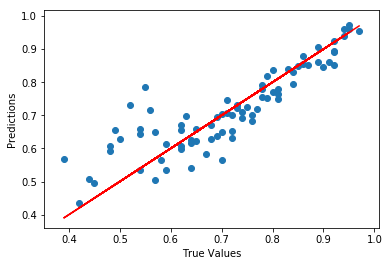

In [14]:
# Fit a model

lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

# Scatter plot of model
plt.scatter(y_test, predictions)
plt.plot(y_test, y_test, color="red")
plt.xlabel('True Values')
plt.ylabel('Predictions')

R-squared of the model in the training set is: 0.8070189399612181
Mean absolute error of the training set is: 0.04466477813994122
Mean squared error of the training set is: 0.0038763856765342422
-----Test set statistics-----
R-squared of the model in the test set is: 0.7675576991588157
Mean absolute error of the prediction is: 0.049345258726725724
Mean squared error of the prediction is: 0.0048700148660740725
Root mean squared error of the prediction is: 0.0697854918021939
Mean absolute percentage error of the prediction is: 8.163179654274748


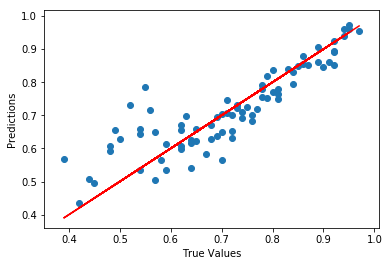

In [15]:
# Now we make predictions
y_preds_train = lm.predict(X_train)
y_preds_test = lm.predict(X_test)

# Scatter plot of prediction model
plt.scatter(y_test, predictions)
plt.plot(y_test, y_test, color="red")
plt.xlabel('True Values')
plt.ylabel('Predictions')


print("R-squared of the model in the training set is: {}".format(lm.score(X_train, y_train)))
print("Mean absolute error of the training set is: {}".format(mean_absolute_error(y_train, y_preds_train)))
print("Mean squared error of the training set is: {}".format(mse(y_train, y_preds_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

In [37]:
# Perform 4-fold cross validation

scores = cross_val_score(model, X, Y , cv=10)
print ("Cross-validated scores: ", scores)
print("Average Cross-validation: ", scores.mean())

Cross-validated scores:  [0.78315954 0.55800891 0.68376455 0.84795894 0.68033154 0.89774252
 0.79350462 0.90217242 0.68715345 0.86557187]
Average Cross-validation:  0.7699368363117893


The training set model has an Rsquared of .80 and the difference in MAE between the training set and the test set is not that significant; .044 versus .049 respectively.  However the MSE of the prediction is substantially higher than that of the training set.  Using cross validation (4 folds) we see a wider than desired range in scores of the model.  Thus the model is overfitting and we will have to apply regularization. 

R-squared of the model on the training set is: 0.7412706575632856
Mean absolute error of the training set is: 0.05437961427093994
Mean squared error of the training set is: 0.005197062949696985
-----Test set statistics-----
R-squared of the model on the test set is: 0.6571005168055405
Mean absolute error of the prediction is: 0.061170053404385784
Mean squared error of the prediction is: 0.007184258522148717
Root mean squared error of the prediction is: 0.08476000543976338
Mean absolute percentage error of the prediction is: 10.044913174116022


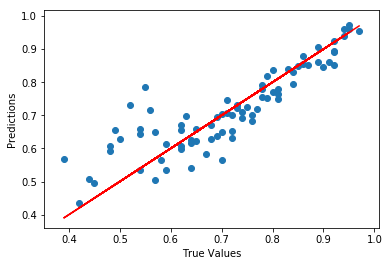

In [38]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**3) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
ry_preds_train = ridgeregr.predict(X_train)
ry_preds_test = ridgeregr.predict(X_test)

# Scatter plot of prediction model
plt.scatter(y_test, predictions)
plt.plot(y_test, y_test, color="red")
plt.xlabel('True Values')
plt.ylabel('Predictions')


print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("Mean absolute error of the training set is: {}".format(mean_absolute_error(y_train, ry_preds_train)))
print("Mean squared error of the training set is: {}".format(mse(y_train, ry_preds_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, ry_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, ry_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, ry_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - ry_preds_test) / y_test)) * 100))


### Build a KNN Regression model

In [18]:
#Define the features for X

Kfeatures=(((testscores['GRE Score']+testscores['TOEFL Score'])//2)*testscores['CGPA'])[:, np.newaxis]
Kfeatures.shape

(400, 1)

In [19]:
#Define data set for KNN model

# Y is the target variable
KY = testscores['Chance of Admit']

# X is the feature set which includes lot GRE, TOEFL and CGPA score
KX = Kfeatures

#Split the data into training and test data

KX_train, KX_test, ky_train, ky_test = train_test_split(KX, KY, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 320
The number of observations in test set is 80


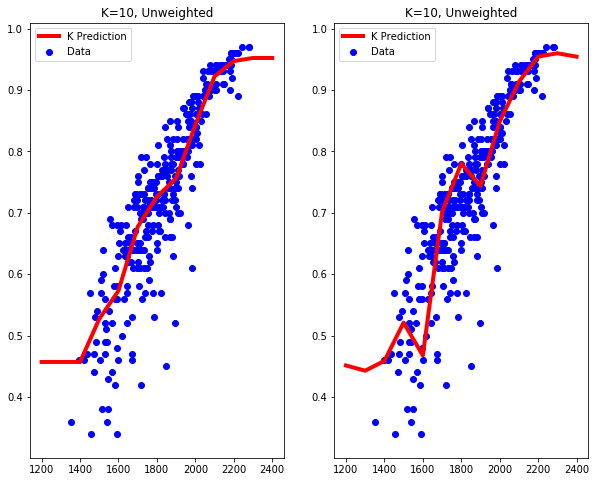

Unweighted Accuracy: 0.75 (+/- 0.13)
Weighted Accuracy: 0.66 (+/- 0.15)


In [20]:
# Build our model.

knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(KX_train, ky_train)

knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w.fit(KX_train, ky_train)


# Set up our prediction line.

T = np.arange(1200, 2500, 100)[:, np.newaxis]  

# Trailing underscores are a common convention for a prediction.
KY_ = knn.predict(T)
KY_w = knn_w.predict(T)


plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.scatter(KX_train, ky_train, c='b', label='Data')
plt.plot(T, KY_, c='r', label='K Prediction', linewidth=4.0)
plt.legend()
plt.title('K=10, Unweighted')

plt.subplot(1,2,2)
plt.scatter(KX_train, ky_train, c='b', label='Data')
plt.plot(T, KY_w, c='r', label='K Prediction', linewidth=4.0)
plt.legend()
plt.title('K=10, Unweighted')

plt.show()

score = cross_val_score(knn, KX, KY, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
          
score_w = cross_val_score(knn_w, KX, KY, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

The unweighted model performed better than the weighted model so we will use an unweighted model

In [45]:
score_val = [] #to store rmse values for different k

for K in range(20):
    K = K+1
    knn = neighbors.KNeighborsRegressor(n_neighbors = K)


    #Fit the model
    knn.fit(KX_train, ky_train) 

    #Make a preditcion on test set
    KY_test_pred= knn.predict(KX_test)
    KY_train_pred=knn.predict(KX_train)
    
    #Calculate the MSE
    #Error = sqrt(mean_squared_error(ky_test, KY_))
    #rmse_val.append(Error) #store mse values
    Rscore_test = knn.score(ky_test, KY_test_pred)
    Rscore_train = knn.score(ky_train, KY_train_pred)
    score_val.append(Rscore_test)
    
    #print('MAE value for k = {1:0} is: {0:.3f} & Predicted value is: {0:.3f}'.format(K, Rscore, KY_test.mean()))    
    print('R Square value for k=' , K, 'is:', Rscore_test, '& Predicted value is:', KY_test_pred.mean())

ValueError: Expected 2D array, got 1D array instead:
array=[0.72 0.84 0.87 0.92 0.92 0.91 0.39 0.69 0.52 0.54 0.89 0.89 0.54 0.48
 0.8  0.86 0.95 0.81 0.64 0.71 0.49 0.74 0.7  0.59 0.86 0.95 0.85 0.44
 0.78 0.9  0.84 0.94 0.74 0.7  0.72 0.78 0.62 0.57 0.54 0.62 0.63 0.94
 0.77 0.64 0.71 0.62 0.78 0.65 0.68 0.72 0.69 0.73 0.64 0.8  0.5  0.68
 0.55 0.65 0.83 0.45 0.92 0.42 0.57 0.48 0.7  0.67 0.76 0.92 0.76 0.79
 0.56 0.73 0.79 0.75 0.59 0.81 0.62 0.58 0.81 0.97].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Text(0.5, 0, 'k Values')

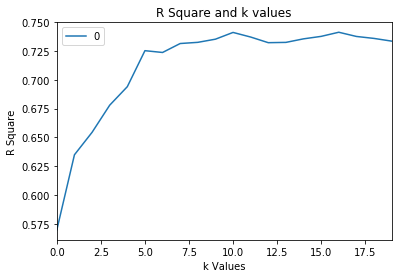

In [40]:
#Plotting the R Square values against k values

#elbow curve 
curve = pd.DataFrame(score_val)
curve.plot()
plt.title('R Square and k values')
plt.ylabel('R Square')
plt.xlabel('k Values')

In [ ]:
#Summary statistics for the KNN Regression model

print("R-squared of the model on the training set is: {0:.03f}".format(knn.score(KX_train, ky_train)))
print("Mean absolute error of the training set is: {0:.03f}".format(mean_absolute_error(ky_train, KY_train_pred)))
print("Mean squared error of the training set is: {0:.05f}".format(mse(ky_train, KY_train_pred)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {0:.03f}".format(knn.score(KX_test, ky_test)))
print("Mean absolute error of the prediction is: {0:.03f}".format(mean_absolute_error(ky_test, KY_test_pred)))
print("Mean squared error of the prediction is: {0:.05f}".format(mse(ky_test, KY_test_pred)))
print("Root mean squared error of the prediction is: {0:.03f}".format(rmse(ky_test, KY_test_pred)))
print("Mean absolute percentage error of the prediction is: {0:.03f}".format(np.mean(np.abs((ky_test - KY_test_pred) / ky_test)) * 100))



For the KNN-Regression the optimal model would have K=5 as indicated by the curve above.  At k=5 the R square the .69.  When  